In [ ]:
import os
import numpy as np
import cv2

path = 'C:/Users/jumpr_000/Desktop/ransac_obstacle_detection/saved'
frames_dir = 'kinect_data/'
directory = os.fsencode(frames_dir)
frame_i = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy"):
        file_path = frames_dir + filename
        print(file_path)
        img = np.uint8(np.load(file_path))
        cv2.imwrite(os.path.join(path ,filename[:-4] + '.png'), img)
cv2.destroyAllWindows()

In [3]:
import os
import numpy as np
import cv2
import time
import math
import pandas as pd
from obstacle_detection import get_obstacles_with_plane
from depth_image_processing import *
import csv
import matplotlib.pyplot as plt
from scipy.optimize import minimize

path = 'kinect_data/'

num_passes = 3
num_planes = np.arange(2,32,2)#[2,5,8,16, 32]
num_points = np.arange(3,32,2)#[3,5,10,16, 32]
dist_thresh = [0.1]

def get_performance(x):
    planes = int(x[0])
    points = int(x[1])
    thresh = int(x[2])
    file_reader= open('test.csv', "rt", encoding='ascii')
    read = list(csv.reader(file_reader))
    
    accuracies = np.array([])
    
    skip = False
    for _ in range(0, num_passes):
        for i in range(0,len(read)):
            if skip:
                skip = False
                continue
            row = read[i]
            img_path = path + row[0][:-4] + '.npy'
            if row[0] == 'img':
                continue
            frame = np.load(img_path)
            label = np.zeros(frame.shape, dtype = np.uint8)
            label = cv2.rectangle(label, (int(row[3]), int(row[5])), (int(row[4]), int(row[6])),(255,255,255), -1)
            if i < len(read) - 1:
                if row[0] == read[i + 1][0]:
                    next_row = read[i + 1]
                    label = cv2.rectangle(label, (int(next_row[3]), int(next_row[5])), (int(next_row[4]), int(next_row[6])),(255,255,255), -1)
                    skip = True



            obstacles = get_obstacles_with_plane(frame, num_planes = planes, 
                                          num_points = points, 
                                          dist_thresh = thresh, 
                                          visualize = False)
            img = np.uint8(obstacles)
            intersect = cv2.bitwise_and(img, label) #find correct detetions
            accuracy = cv2.countNonZero(intersect) #count number of pixels correctly detected
            incorrect = cv2.countNonZero(cv2.subtract(img,label)) #count pixels outside of label
            truth = cv2.countNonZero(label)
            #print('Accuracy:', accuracy, 'Incorrect:', incorrect)
            accuracies = np.append(accuracies, incorrect / truth)
            key = cv2.waitKey(delay=1)
    return np.mean(accuracies)



#x0 = [10, 5, 0.1]
#res = minimize(get_performance, x0, method='nelder-mead',
#               options={'xtol': 1e-8, 'disp': True}) 

performance_graph = np.array([])
planes_graph = np.array([])
points_graph = np.array([])
thresh_graph = np.array([])
time_graph = np.array([])
steps = np.array([])
step = 0
min_params = [10,5,.1]
loss_graph = np.array([])
global_min_graph = np.array([])
global_min = 1.0
min_loss = 1.0
epoch = 0
n_iter = len(dist_thresh) * len(num_points) * len(num_planes)
print(n_iter)
iter_i = 1
for thresh in dist_thresh:
    for point in num_points:
        current_min_loss = np.array([])
        current_time = np.array([])
        current_loss = np.array([])
        min_loss = 1.0
        for plane in num_planes:
            start_time = time.time()
            steps = np.append(steps, step)
            points_graph = np.append(points_graph, point)
            planes_graph = np.append(planes_graph, plane)
            thresh_graph = np.append(thresh_graph, thresh)
            performance = get_performance([plane, point, thresh])
            if math.isnan(performance):
                performance = 1.0
            if performance < min_loss:
                #print('New min:')
                #print('num_planes',plane,'num_points', point,'dist_thresh', thresh,'loss', performance)
                min_loss = performance
            if performance < global_min:
                print('New global min:')
                print('num_planes',plane,'num_points', point,'dist_thresh', thresh,'loss', performance)
                global_min = performance
                
                min_params = [plane, point, thresh]
            global_min_graph = np.append(global_min_graph, global_min)
            current_min_loss = np.append(current_min_loss, min_loss)
            #performance_graph = np.append(performance_graph, performance)
            current_loss = np.append(current_loss, performance)
            print('iter',iter_i,'/',n_iter)
            if iter_i % (n_iter / 10) == 0:
                percent = (iter_i / n_iter) * 100
                print(percent, "% done")
            iter_i += 1
            current_time = np.append(current_time, time.time() - start_time)
            step += 1
        if epoch == 0:
            performance_graph = np.append(performance_graph, current_loss)
            loss_graph = np.append(loss_graph, current_min_loss)
            time_graph = np.append(time_graph, current_time)
        else:
            performance_graph = np.vstack((performance_graph, current_loss))
            time_graph = np.vstack((time_graph, current_time))
            loss_graph = np.vstack((loss_graph, current_min_loss))
        epoch += 1

            
rows = 1
cols = 4
y_lists = {'loss':performance_graph,
           'min_loss':loss_graph,
           'global_min': global_min_graph,
           'seconds': time_graph}
graph_labels = list(y_lists.keys())
fig, axes = plt.subplots(rows, cols, figsize=(20,6))
fig.patch.set_facecolor('white')
for i in range(1,5):
    sub = plt.subplot(rows, cols, i)
    sub.set_title(graph_labels[i-1])
    if graph_labels[i-1] == 'min_loss' or graph_labels[i-1] == 'loss' or graph_labels[i-1] == 'seconds':
        for graph in y_lists[graph_labels[i-1]]:
            if graph_labels[i-1] == 'min_loss':
                plt.xlabel('Number of planes considered')
                plt.ylabel('Percent of incorrect detections')
            plt.plot(graph)
    else:
        plt.xlabel('Parameters tested')
        plt.yabel('Percent of incorrect detections')
        plt.plot(y_lists[graph_labels[i-1]])
plt.tight_layout()
plt.show()

print('Optimal params:',min_params)


225


C:\Users\jumpr_000\AppData\Roaming\Python\Python35\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jumpr_000\AppData\Roaming\Python\Python35\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\jumpr_000\Desktop\ransac_obstacle_detection\obstacle_detection.py:110: RuntimeWarning: invalid value encountered in less
  if mean_val < HIGH_DISTANCE_BOUND: #kinect loses accuracy beyond 4.5m


New global min:
num_planes 2 num_points 3 dist_thresh 0.1 loss 0.11191062370221658
iter 1 / 225
New global min:
num_planes 4 num_points 3 dist_thresh 0.1 loss 0.08475619852971317
iter 2 / 225
iter 3 / 225
iter 4 / 225
iter 5 / 225
iter 6 / 225
iter 7 / 225
iter 8 / 225
iter 9 / 225
iter 10 / 225
iter 11 / 225
iter 12 / 225
iter 13 / 225
iter 14 / 225
iter 15 / 225
iter 16 / 225
iter 17 / 225
iter 18 / 225
iter 19 / 225
iter 20 / 225
iter 21 / 225
iter 22 / 225
iter 23 / 225
iter 24 / 225
iter 25 / 225
iter 26 / 225
iter 27 / 225
iter 28 / 225
iter 29 / 225
iter 30 / 225
iter 31 / 225
iter 32 / 225
iter 33 / 225
iter 34 / 225
iter 35 / 225
iter 36 / 225
iter 37 / 225
iter 38 / 225
iter 39 / 225
iter 40 / 225
iter 41 / 225
iter 42 / 225
iter 43 / 225
iter 44 / 225
iter 45 / 225
20.0 % done
iter 46 / 225
iter 47 / 225
iter 48 / 225
iter 49 / 225
iter 50 / 225
iter 51 / 225
iter 52 / 225
New global min:
num_planes 16 num_points 9 dist_thresh 0.1 loss 0.06567491538494492
iter 53 / 225
iter 

AttributeError: module 'matplotlib.pyplot' has no attribute 'yabel'

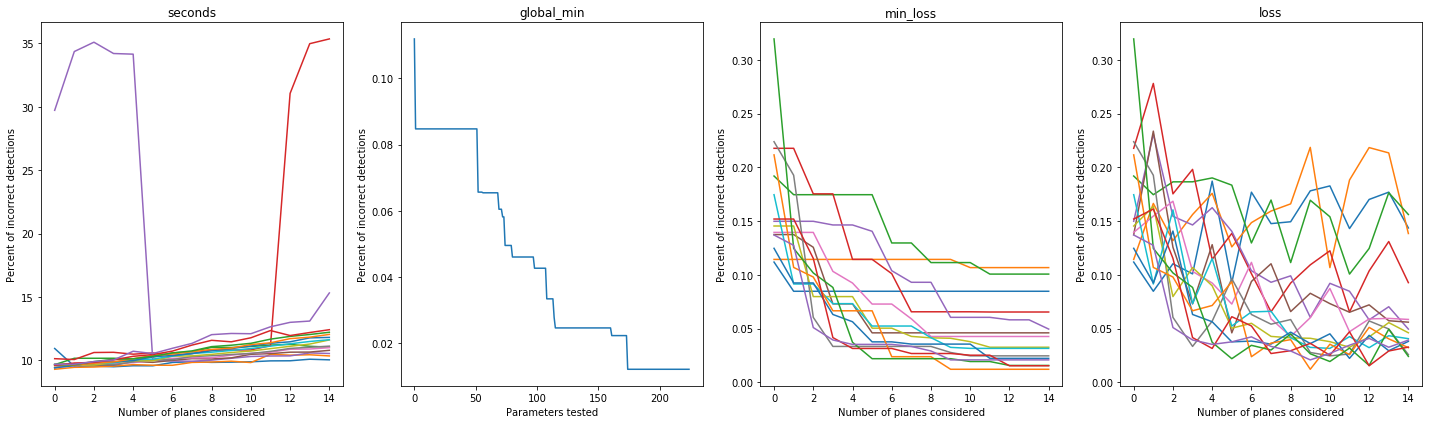

Optimal params: [20, 25, 0.1]


In [15]:
rows = 1
cols = 4
y_lists = {'loss':performance_graph,
           'min_loss':loss_graph,
           'global_min': global_min_graph,
           'seconds': time_graph}
graph_labels = list(y_lists.keys())
fig, axes = plt.subplots(rows, cols, figsize=(20,6))
fig.patch.set_facecolor('white')
for i in range(1,5):
    sub = plt.subplot(rows, cols, i)
    sub.set_title(graph_labels[i-1])
    if graph_labels[i-1] == 'min_loss' or graph_labels[i-1] == 'loss' or graph_labels[i-1] == 'seconds':
        for graph in y_lists[graph_labels[i-1]]:
            plt.xlabel('Number of planes considered')
            plt.ylabel('Percent of incorrect detections')
            plt.plot(graph)
    else:
        plt.xlabel('Parameters tested')
        plt.ylabel('Percent of incorrect detections')
        plt.plot(y_lists[graph_labels[i-1]])
plt.tight_layout()
plt.show()

print('Optimal params:',min_params)